Step 0.1. Подгружаем библиотеки

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Step 0.2. Подгружаем данные 
в переменную data_path указать ссылку на вашу директорию

In [10]:
data_path = "/content/drive/MyDrive/Colab Notebooks"
expression_data = pd.read_csv(f"{data_path}/homework_lecture_5_data.csv", index_col=0)
expression_data.head()

,TMCC1,RANBP3,GABRG3,ARRDC5,LRP3,TIMM23,TBPL1,BIRC8,TTC28,C19orf66,...,MAGEA6,IL4I1,LCN12,SMG6,C1orf100,WDR75,ZBTB26,SPTY2D1,PLEKHA2,Cell_type
0,33.888550,38.384340,0.044721,1.385159,11.341853,105.193306,26.463990,0.000000,1.537873,27.645407,...,21.332443,1.397932,0.000000,23.136585,0.001902,60.218548,6.307399,9.577274,44.026940,B_cell
1,16.497124,35.054090,0.314645,4.329797,8.649321,50.577618,16.684614,0.000000,1.796609,13.715611,...,1.199440,159.147130,0.259244,18.986986,0.310971,25.818224,4.193348,14.181196,35.779896,B_cell
2,5.449933,31.783958,0.002949,2.137536,1.750892,109.201050,35.265984,0.011501,0.878889,19.361662,...,0.002924,25.256378,0.000000,32.941895,0.000000,99.555990,8.323141,29.321960,30.816538,B_cell
3,33.362240,56.147026,0.037295,1.604904,6.807299,100.141620,25.446817,0.000000,2.502661,12.745437,...,0.000000,14.509516,0.063003,19.036896,0.000000,49.394980,4.655794,17.683067,47.143270,B_cell
4,50.188510,30.165264,0.039678,1.501439,1.619954,46.916790,28.053373,0.018181,1.165164,30.318027,...,0.033807,93.681190,0.031816,19.094831,0.000000,20.201437,6.935232,20.769829,53.935143,B_cell


Step 0.3.  Создаём переменные для клеточных типов: B-клетки и NK-клетки

In [12]:
b_cells_expression_data = expression_data.query("Cell_type == 'B_cell'")
nk_cells_expression_data = expression_data.query("Cell_type == 'NK_cell'")

In [14]:
example_gene = "TMCC1"

# Step 1.

Функция, которая будет принимает на вход экспрессии гена, семплирует из них выборки размера sample_size, считает среднюю экспрессию и повторяет это n_samples раз:

In [15]:
def demonstrate_clt(expressions, sample_size, n_samples):
    mean_expressions = [expressions[i*sample_size: (i+1)*sample_size].sum()/n_samples for i in range(n_samples)]

    return mean_expressions

b_mean = demonstrate_clt(b_cells_expression_data[example_gene], 100, 100)
nk_mean = demonstrate_clt(nk_cells_expression_data[example_gene], 100, 100)

Применили функцию к экспрессиям гена TMCC1 в обоих клеточных типах, визуализировали. Средние экспрессии данного гена у этих клеточных типов отличаются.

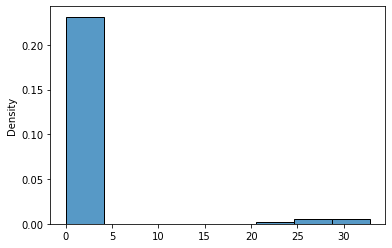

In [16]:
sns.histplot(b_mean, stat="density");

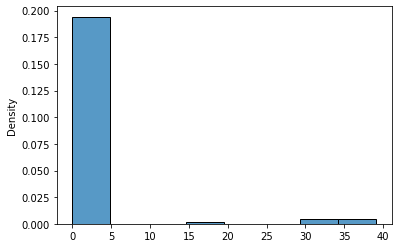

In [17]:
sns.histplot(nk_mean, stat="density");

Посчитайтаем 95% доверительных интервалов для обоих распределений:

In [18]:
b_m = b_cells_expression_data[example_gene].sum()/len(b_cells_expression_data[example_gene])
nk_m = nk_cells_expression_data[example_gene].sum()/len(nk_cells_expression_data[example_gene])

print(b_m)
print(nk_m)

26.978971829200002
30.4313196004


In [19]:
import math

b_sd = math.sqrt(b_cells_expression_data[example_gene].var(ddof = 1))
nk_sd = math.sqrt(nk_cells_expression_data[example_gene].var(ddof = 1))

print(b_sd)
print(nk_sd)

40.5017332409003
40.80350349863318


In [20]:
b_z = b_sd/math.sqrt(len(b_cells_expression_data[example_gene]))*1.96
print(b_z)

b_95_int = [b_m-b_z, b_m+b_z]
print(b_95_int)

3.5501334463420644
[23.42883838285794, 30.529105275542065]


In [21]:
nk_z = nk_sd/math.sqrt(len(nk_cells_expression_data[example_gene]))*1.96
print(nk_z)

nk_95_int = [nk_m-nk_z, nk_m+nk_z]
print(nk_95_int)

3.5765847756892954
[26.854734824710704, 34.00790437608929]


# Step 2

In [22]:
import scipy.stats as st

Функция для проверки того, что доверительные интервалы пересекаются:

In [23]:
def check_intervals_intersect(first_ci, second_ci):
  are_intersect = False
  if (second_ci[0] >= first_ci[0] and second_ci[0]<= first_ci[1] or first_ci[0] >= second_ci[0] and first_ci[0]<= second_ci[1]):
    are_intersect = True
  return are_intersect

Считаем доверительные интервалы в обоих клеточных типах, они пересекаются

In [24]:
print(check_intervals_intersect(nk_95_int, b_95_int))

True


Функция, которая будет принимать на вход две таблицы с экспрессиями и выдаёт для каждого гена, значимо ли отличается его средняя экспрессия между клеточными типами

In [25]:
def check_dge_with_ci(first_table, second_table): 
  ci_test_result = []
  for col in first_table:
    first_int = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(first_table[col]) - 1, # число степеней свободы - 1
              loc=np.mean(first_table[col]), # Среднее
              scale=st.sem(first_table[col])) # Стандартная ошибка среднего
    second_int = st.t.interval(alpha=0.95, # 95% доверительный интервал
              df=len(second_table[col]) - 1, # число степеней свободы - 1
              loc=np.mean(second_table[col]), # Среднее
              scale=st.sem(second_table[col])) # Стандартная ошибка среднего
    ci_test_result.append(check_intervals_intersect(first_int, second_int))
  return ci_test_result

In [ ]:
check_dge_with_ci(b_cells_expression_data.drop('Cell_type', axis = 1), nk_cells_expression_data.drop('Cell_type', axis = 1)) 

# Step 3

Применим для той же задачи z-критерий. Будем считать, что в данном случае 𝛼 = 0.05, и если полученное p-value будет меньше, то экспрессия генов значимо отличается.

In [29]:
from statsmodels.stats.weightstats import ztest

In [30]:
# Наш излюбленный ген
ztest(
    b_cells_expression_data[example_gene],
    nk_cells_expression_data[example_gene]
)

(-1.3427434041885127, 0.17935507499860204)

ФункциЯ, которая принимает на вход две таблицы с экспрессиями и выдает для каждого гена, значимо ли отличается его средняя экспрессия между клеточными типами.

In [31]:
def check_dge_with_ztest(first_table, second_table): 
  z_test_result = []
  for col in first_table: 
    tz = ztest(first_table[col], second_table[col])
    if tz[1]<0.05: z_test_result.append(True)
    else: z_test_result.append(False)
  return z_test_result

In [ ]:
check_dge_with_ztest(b_cells_expression_data.drop('Cell_type', axis = 1), nk_cells_expression_data.drop('Cell_type', axis = 1))

# Step 4

Программа, которая принимает на вход следующие аргуметры:

first_cell_type_expressions_path – путь до таблицы с экспрессиями генов для одного клеточного типа;

second_cell_type_expressions_path – путь до таблицы с экспрессиями генов для второго клеточного типа;

save_results_table – название таблицы с результатами.


In [33]:
b_cells_expression_data.drop('Cell_type', axis = 1).to_csv('/content/drive/MyDrive/Colab Notebooks/b.csv')
nk_cells_expression_data.drop('Cell_type', axis = 1).to_csv('/content/drive/MyDrive/Colab Notebooks/nk.csv')

In [35]:
first_cell_type_expressions_path = input()
second_cell_type_expressions_path = input()
save_results_table = input()

table_1 = pd.read_csv(first_cell_type_expressions_path, index_col=0)
table_2 = pd.read_csv(second_cell_type_expressions_path, index_col=0)

ci = check_dge_with_ci(table_1, table_2)
z = check_dge_with_ztest(table_1, table_2)

results = {
    "ci_test_results": ci,
    "z_test_results": z
}

results = pd.DataFrame(results)
results.to_csv(save_results_table)

/content/drive/MyDrive/Colab Notebooks/b.csv
/content/drive/MyDrive/Colab Notebooks/nk.csv
/content/drive/MyDrive/Colab Notebooks/res.csv
